# Settings

## Constant

In [1]:
import pytz
import os


DEFAULT_TZ = pytz.FixedOffset(540)  # GMT+09:00; Asia/Seoul

PATH_DATA = './data'
PATH_ESM = os.path.join(PATH_DATA, 'EsmResponse.csv')
PATH_PARTICIPANT = os.path.join(PATH_DATA, 'UserInfo.csv')
PATH_SENSOR = os.path.join(PATH_DATA, 'Sensor')

PATH_INTERMEDIATE = './intermediate'

DATA_TYPES = {
    'EDA': 'EDA',
    'HR': 'HRT',
    'RRI': 'RRI',
    'SkinTemperature': 'SKT',
}


## Utility Functions

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import cloudpickle
import ray
from datetime import datetime
from contextlib import contextmanager
import warnings
import time


def load(path: str):
    with open(path, mode='rb') as f:
        return cloudpickle.load(f)

    
def dump(obj, path: str):
    with open(path, mode='wb') as f:
        cloudpickle.dump(obj, f)
        
    
def log(msg: any):
    print('[{}] {}'.format(datetime.now().strftime('%y-%m-%d %H:%M:%S'), msg))


def summary(x):
    x = np.asarray(x)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        n = len(x)
        # Here, uppercase np.dtype.kind corresponds to non-numeric data.
        # Also, we view the boolean data as dichotomous categorical data.
        if x.dtype.kind.isupper() or x.dtype.kind == 'b': 
            cnt = pd.Series(x).value_counts(dropna=False)
            card = len(cnt)
            cnt = cnt[:20]                
            cnt_str = ', '.join([f'{u}:{c}' for u, c in zip(cnt.index, cnt)])
            if card > 30:
                cnt_str = f'{cnt_str}, ...'
            return {
                'n': n,
                'cardinality': card,
                'value_count': cnt_str
            }
        else: 
            x_nan = x[np.isnan(x)]
            x_norm = x[~np.isnan(x)]
            
            tot = np.sum(x_norm)
            m = np.mean(x_norm)
            me = np.median(x_norm)
            s = np.std(x_norm, ddof=1)
            l, u = np.min(x_norm), np.max(x)
            conf_l, conf_u = st.t.interval(0.95, len(x_norm) - 1, loc=m, scale=st.sem(x_norm))
            n_nan = len(x_nan)
            
            return {
                'n': n,
                'sum': tot,
                'mean': m,
                'SD': s,
                'med': me,
                'range': (l, u),
                'conf.': (conf_l, conf_u),
                'nan_count': n_nan
            }


@contextmanager
def on_ray(*args, **kwargs):
    try:
        if ray.is_initialized():
            ray.shutdown()
        ray.init(*args, **kwargs)
        yield None
    finally:
        ray.shutdown()

## Settings for R

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R

library(tidyverse)
library(ggforce)
library(ggpubr)
library(showtext)
library(rmcorr)
library(patchwork)

# font_add_google(
#     name='Source Serif Pro',
#     family='ssp',
#     db_cache=FALSE
# )

showtext_auto()

THEME_DEFAULT <- theme_bw(
    base_size=10,
    base_family='ssp',
) + theme(
        axis.title.x=element_text(colour='grey20', size=10, face='bold'),
        axis.title.y=element_text(colour='grey20', size=10, face='bold'),
        axis.text.x=element_text(colour='grey20', size=10),
        axis.text.y=element_text(colour='grey20', size=10),
        strip.text.x=element_text(colour='grey20', size=10, face='bold'),
        strip.text.y=element_text(colour='grey20', size=10, face='bold'),
        legend.background=element_blank(),
        legend.title=element_text(colour='grey20', size=10, face='bold'),
        legend.text=element_text(colour='grey20', size=10),
        legend.position='top',
        legend.box.spacing= unit(0, 'cm'),
        plot.subtitle=element_text(colour='grey20', size=10, hjust=.5),
    )


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: 필요한 패키지를 로딩중입니다: sysfonts

R[write to console]: 필요한 패키지를 로딩중입니다: showtextdb



# Dataset Overview

## Participants

In [5]:
import pandas as pd
import os


PARTICIPANTS = pd.read_csv(PATH_PARTICIPANT).set_index('pcode').assign(
    particpationStartDateTime=lambda x: pd.to_datetime(
        x['participationStartDate'], format='%Y-%m-%d'
    ).dt.tz_localize(DEFAULT_TZ)
)
PARTICIPANTS.head()

,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ,particpationStartDateTime
pcode,,,,,,,,,,,,
P01,2019-05-08,27,M,11,11,3,4,13,13,0,1,2019-05-08 00:00:00+09:00
P02,2019-05-08,21,M,14,5,12,14,5,27,6,18,2019-05-08 00:00:00+09:00
P03,2019-05-08,24,F,10,15,8,7,11,18,2,6,2019-05-08 00:00:00+09:00
P04,2019-05-08,23,M,12,11,8,6,11,20,1,9,2019-05-08 00:00:00+09:00
P05,2019-05-08,27,F,10,11,13,10,6,25,14,9,2019-05-08 00:00:00+09:00


Belows are some demographics:

In [6]:
for c in PARTICIPANTS.columns:
    print(f'- {c}:', summary(PARTICIPANTS[c]))

- participationStartDate: {'n': 77, 'cardinality': 3, 'value_count': '2019-05-08:27, 2019-05-16:25, 2019-04-30:25'}
- age: {'n': 77, 'sum': 1686, 'mean': 21.896103896103895, 'SD': 3.8613619617422406, 'med': 21.0, 'range': (17, 38), 'conf.': (21.01968223607122, 22.77252555613657), 'nan_count': 0}
- gender: {'n': 77, 'cardinality': 2, 'value_count': 'M:53, F:24'}
- openness: {'n': 77, 'sum': 787, 'mean': 10.220779220779221, 'SD': 2.8956563505732467, 'med': 11.0, 'range': (3, 15), 'conf.': (9.563545847995773, 10.87801259356267), 'nan_count': 0}
- conscientiousness: {'n': 77, 'sum': 820, 'mean': 10.64935064935065, 'SD': 2.3662441579221882, 'med': 11.0, 'range': (5, 15), 'conf.': (10.112279104782713, 11.186422193918586), 'nan_count': 0}
- neuroticism: {'n': 77, 'sum': 618, 'mean': 8.025974025974026, 'SD': 2.6900108881310953, 'med': 8.0, 'range': (3, 14), 'conf.': (7.4154164477308075, 8.636531604217245), 'nan_count': 0}
- extraversion: {'n': 77, 'sum': 703, 'mean': 9.12987012987013, 'SD': 3.

## Labels (via ESM)

In [7]:
import pandas as pd
import os


LABELS = pd.read_csv(PATH_ESM).set_index(
    ['pcode']
)
LABELS.head()

,responseTime,scheduledTime,valence,arousal,attention,stress,duration,disturbance,change
pcode,,,,,,,,,
P01,1557278103000,NaN,0,0,0,-1,20.0,3,-2
P01,1557278986000,1.557279e+12,-3,3,3,3,5.0,-1,-3
P01,1557281772000,1.557282e+12,-3,-2,2,2,15.0,3,-2
P01,1557287138000,NaN,2,-1,2,0,15.0,1,-1
P01,1557291117000,NaN,3,3,3,-3,20.0,1,0


In [8]:
for c in LABELS.columns:
    print(f'- {c}:', summary(LABELS[c]))

- responseTime: {'n': 5582, 'sum': 8694314195328000, 'mean': 1557562557385.8833, 'SD': 590915040.4254278, 'med': 1557562969500.0, 'range': (1556582982000, 1558545246000), 'conf.': (1557547052362.8618, 1557578062408.9048), 'nan_count': 0}
- scheduledTime: {'n': 5582, 'sum': 5175814282500000.0, 'mean': 1557572760306.9517, 'SD': 591697484.8543198, 'med': 1557565860000.0, 'range': (1556586120000.0, nan), 'conf.': (1557552635074.4736, 1557592885539.4297), 'nan_count': 2259}
- valence: {'n': 5582, 'sum': 3665, 'mean': 0.6565747044070226, 'SD': 1.4184297545899174, 'med': 1.0, 'range': (-3, 3), 'conf.': (0.6193565182132938, 0.6937928906007513), 'nan_count': 0}
- arousal: {'n': 5582, 'sum': -529, 'mean': -0.09476890003582945, 'SD': 1.6675313128774563, 'med': 0.0, 'range': (-3, 3), 'conf.': (-0.13852326339835566, -0.051014536673303246), 'nan_count': 0}
- attention: {'n': 5582, 'sum': 2236, 'mean': 0.4005732712289502, 'SD': 1.6113242733571864, 'med': 1.0, 'range': (-3, 3), 'conf.': (0.35829372468

Belows are some demographics:

In [9]:
inst = LABELS.groupby('pcode').count().iloc[:, -1]
inst_sch = LABELS.loc[lambda x: ~x['scheduledTime'].isna(), :].groupby('pcode').count().iloc[:, -1]
inst_vol = LABELS.loc[lambda x: x['scheduledTime'].isna(), :].groupby('pcode').count().iloc[:, -1]
resp_time = LABELS.assign(
    timestamp=lambda x: pd.to_datetime(x['responseTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
)
sam = np.concatenate([
    (resp_time.loc[p, 'timestamp'].array - resp_time.loc[p, 'timestamp'].array.shift(1)).dropna().total_seconds()
    for p in LABELS.index.unique()
])

print('- # Inst.:', summary(inst))
print('- # Inst. - Scheduled:', summary(inst_sch))
print('- # Inst. - Voluntary:', summary(inst_vol))
print('- Samp. period:', summary(sam))
for c in LABELS.columns:
    print(f'- {c}:', summary(LABELS[c]))

- # Inst.: {'n': 77, 'sum': 5582, 'mean': 72.49350649350649, 'SD': 16.02270048911147, 'med': 74.0, 'range': (20, 110), 'conf.': (68.85679957506535, 76.13021341194762), 'nan_count': 0}
- # Inst. - Scheduled: {'n': 76, 'sum': 3323, 'mean': 43.723684210526315, 'SD': 19.36291898394835, 'med': 43.5, 'range': (3, 83), 'conf.': (39.29906768289902, 48.14830073815361), 'nan_count': 0}
- # Inst. - Voluntary: {'n': 77, 'sum': 2259, 'mean': 29.337662337662337, 'SD': 16.297893300742235, 'med': 27.0, 'range': (2, 74), 'conf.': (25.6384943127028, 33.03683036262187), 'nan_count': 0}
- Samp. period: {'n': 5505, 'sum': 42240670.0, 'mean': 7673.146230699364, 'SD': 13193.471538029606, 'med': 3090.0, 'range': (1.0, 136446.0), 'conf.': (7324.548923384188, 8021.743538014541), 'nan_count': 0}
- responseTime: {'n': 5582, 'sum': 8694314195328000, 'mean': 1557562557385.8833, 'SD': 590915040.4254278, 'med': 1557562969500.0, 'range': (1556582982000, 1558545246000), 'conf.': (1557547052362.8618, 1557578062408.9048)

### Plot

In [10]:
data = LABELS.loc[
    :, lambda x: ~x.columns.isin(['responseTime', 'scheduledTime'])
]

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


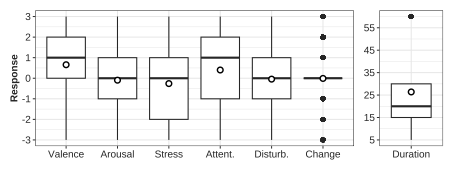

In [11]:
%%R -i data -w 16 -h 6 -u cm

data <- data %>% pivot_longer(
    cols = c('valence', 'arousal', 'attention', 'stress', 'duration', 'disturbance', 'change'),
    names_to = 'metric'
)

p_rest <- ggplot(
    data %>% filter(metric != 'duration'), aes(x=metric, y=value)
) + geom_boxplot(
) + geom_point(
    data = data %>% filter(
        metric != 'duration'
    ) %>% group_by(
        metric
    ) %>% summarise(
        mean = mean(value, na.rm=TRUE)
    ),
    mapping=aes(x=metric, y=mean),
    shape=21,
    stroke=1,
    size=2,
    fill='white'
) + scale_x_discrete(
    name=NULL,
    limits=c('valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'),
    labels=c('Valence', 'Arousal', 'Stress', 'Attent.', 'Disturb.', 'Change'),
) + scale_y_continuous(
    name='Response',
    breaks=-3:3
) + THEME_DEFAULT

p_duration <- ggplot(
    data %>% filter(metric == 'duration'), aes(x=metric, y=value)
) + geom_boxplot(
) + geom_point(
    data = data %>% filter(
        metric == 'duration'
    ) %>% group_by(
        metric
    ) %>% summarise(
        mean = mean(value, na.rm=TRUE)
    ),
    mapping=aes(x=metric, y=mean),
    shape=21,
    stroke=1,
    size=2,
    fill='white'
)+ scale_x_discrete(
    name=NULL,
    limits=c('duration'),
    labels=c('Duration'),
) + scale_y_continuous(
    name=NULL,
    breaks=seq(from=5, to=60, by=10)
) + THEME_DEFAULT

p <- p_rest + p_duration + plot_layout(widths=c(4, 0.8))
ggsave('./fig/dist-labels.pdf', plot=p, width=16, height=6, unit='cm', device=cairo_pdf)
print(p)

### Correlation

Because each participant reported their labels multiple times (i.e., repeated measure), repeated measure correlation between affect labels were used.

In [12]:
data = LABELS.reset_index()[[
    'pcode', 'valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'
]]

In [13]:
%%R -i data 

com <- combn(c('valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'), 2)

for(i in 1:ncol(com)) {
    a <- com[, i][1]
    b <- com[, i][2]
    r <- rmcorr(participant = 'pcode', measure1=a, measure2=b, dataset=data)
    cat(a, '-', b, ': R =', r$r, '(p =', r$p, ') \n')
}

valence - arousal : R = 0.3858505 (p = 6.005105e-195 ) 
valence - stress : R = -0.5918317 (p = 0 ) 
valence - attention : R = 0.2880379 (p = 1.138238e-105 ) 
valence - disturbance : R = -0.02946216 (p = 0.02880521 ) 
valence - change : R = 0.3163849 (p = 2.978458e-128 ) 
arousal - stress : R = -0.2020498 (p = 8.095612e-52 ) 
arousal - attention : R = 0.4354836 (p = 1.162341e-253 ) 
arousal - disturbance : R = 0.0284022 (p = 0.03507786 ) 
arousal - change : R = 0.1673468 (p = 7.1899e-36 ) 
stress - attention : R = -0.1515681 (p = 1.176714e-29 ) 
stress - disturbance : R = 0.08679844 (p = 1.108432e-10 ) 
stress - change : R = -0.2907816 (p = 9.560751e-108 ) 
attention - disturbance : R = 0.1182107 (p = 1.363257e-18 ) 
attention - change : R = 0.1163492 (p = 4.682081e-18 ) 
disturbance - change : R = -0.2216444 (p = 3.009815e-62 ) 


## Sensor Data

In [14]:
import os
import pandas as pd
from typing import Optional


def _load_data(
    name: str
) -> Optional[pd.DataFrame]:
    paths = [
        (d, os.path.join(PATH_SENSOR, d, f'{name}.csv'))
        for d in os.listdir(PATH_SENSOR)
        if d.startswith('P')
    ]
    return pd.concat(
        filter(
            lambda x: len(x.index), 
            [
                pd.read_csv(p).assign(pcode=pcode)
                for pcode, p in paths
                if os.path.exists(p)
            ]
        ), ignore_index=True
    ).assign(
        timestamp=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
    ).set_index(
        ['pcode', 'timestamp']
    )

In [ ]:
import pandas as pd
import gc
from datetime import timedelta as td


STATS = []

for data_type in DATA_TYPES:
    dat = _load_data(data_type)
    inst = dat.groupby('pcode').count().iloc[:, -1]
    samp = np.concatenate([
        (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()
        for p in dat.index.get_level_values('pcode').unique()
    ])
    inst, samp = summary(inst), summary(samp)
    
    print('#'*5, data_type, '#'*5)
    print('- # Inst.:', inst)
    print('- Samp. period:', samp)
    
    for c in dat.columns:
        print(f'- {c}:', summary(dat[c]))
        
    del dat
    gc.collect()
    
STATS = pd.DataFrame(STATS)

# Preprocessing

## Label

Because we intended to collected participants' responses to ESMs not voluntary responses, we screend out some responses as follows:
* We first screen out ESM responses that does not have 'scheduledTime' (meaning that a given ESM was expired or participants voluntarily reported their affective states regardless of ESM delivery). 
* Since we will evaluate our model using LOSO, the small number of responses for each participant might lead to inappropriate performance evaluation. We emprically set the number of the minimum responses upon ESM delivery as 5 per day (i.e., a half of our guides), so that we excluded participants whose responses to ESM less than 35.

In [ ]:
LABELS_VALID = LABELS.loc[
    lambda x: ~x['scheduledTime'].isna(), :
]
print(f'# Non-voluntary response: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

excl_pcode = LABELS_VALID.loc[
    lambda x: ~x['scheduledTime'].isna()
].groupby('pcode').count().iloc[:, -1].loc[lambda y: y < 35]

LABELS_VALID = LABELS_VALID.loc[
    lambda x:  ~x.index.get_level_values('pcode').isin(excl_pcode.index), :
]
print(f'# Response from participants with enough responses: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

print('# Participants whose responses to ESM delivery were less then 35')
print(excl_pcode, f'#participants = {len(excl_pcode)} / #response = {sum(excl_pcode)}')

Here we consider binary classifications for valence, arousal, stress, and disturbance, in which a label value greater than 0 is "HIGH" (1) and the rest is "LOW" (0), at the arrival of ESM prompts (*scheduledTime*)

In [ ]:
import pandas as pd
import numpy as np

LABELS_PROC = (
    LABELS_VALID
    .reset_index()
    .assign(
        timestamp=lambda x: pd.to_datetime(x['scheduledTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ),
        attention_bin=lambda x: np.where(x['attention'] > 0, 1, 0)
    )
    .loc[:, ['pcode', 'timestamp', 'attention', 'attention_bin']]  # attention: 연속형, attention_bin: 이진분류된 데이터
    .set_index(['pcode', 'timestamp'])
)

LABELS_PROC.head()

In [ ]:
import numpy as np


inst = LABELS_PROC.groupby('pcode').count().iloc[:, -1]
for c in [c for c in LABELS_PROC.columns if c.endswith('_bin')]:
    print(f'- {c}:', summary(LABELS_PROC[c].astype(object)))

## Sensor Data

For each type of sensor data, we applied different preprocessing. Detailed decsription is provided in the paper.



### Implementation

In [ ]:
import pandas as pd
import numpy as np
import scipy.spatial.distance as dist
from typing import Dict, Union
import pygeohash as geo
from datetime import timedelta
from collections import defaultdict
# SkinTemperature.csv
def _proc_skin_temperature(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['temperature'].astype('float32')


# RRI.csv
def _proc_rri(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['interval'].astype('float32')


# HR.csv
def _proc_hr(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['bpm'].astype('float32')
    

# EDA.csv

def _proc_eda(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    resistance = data['resistance'].astype('float32')

    # log변환 + 0을 엡실론으로
    epsilon = 1e-3
    log_resistance = np.log(resistance + epsilon)

    # 이상치 탐지
    z = zscore(log_resistance)

    # 이상치 NaN으로 → 보간
    log_resistance[z > 3] = np.nan
    log_resistance = log_resistance.interpolate(method='linear')

    # 기존 코드와 이름, 타입 일치
    log_resistance.name = 'resistance'
    return log_resistance

### Execution

In [ ]:
import pandas as pd
import gc
from functools import reduce

FUNC_PROC = {
    'EDA': _proc_eda,
    'HR': _proc_hr,
    'RRI': _proc_rri,
    'SkinTemperature': _proc_skin_temperature,
}


def _process(data_type: str):
    log(f'Begin to processing data: {data_type}')
    
    abbrev = DATA_TYPES[data_type]
    data_raw = _load_data(data_type)
    data_proc = FUNC_PROC[data_type](data_raw)
    result = dict()
    
    if type(data_proc) is dict:
        for k, v in data_proc.items():
            result[f'{abbrev}_{k}'] = v
    else:
        result[abbrev] = data_proc
        
    log(f'Complete processing data: {data_type}')
    return result



with on_ray(num_cpus=12):
    jobs = []
    
    func = ray.remote(_process).remote
    
    for data_type in DATA_TYPES:
        job = func(data_type)
        jobs.append(job)

    jobs = ray.get(jobs)
    jobs = reduce(lambda a, b: {**a, **b}, jobs)
    dump(jobs, os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))

    del jobs
    gc.collect()

In [ ]:
import os
import gc


DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))
#categorial, numeric 변수 수 계산
N_NUMERIC, N_CATEGORICAL = 0, 0

for k, v in DATA.items():
    if v.dtype.kind.isupper() or v.dtype.kind == 'b': 
        N_CATEGORICAL = N_CATEGORICAL + 1
    else:
        N_NUMERIC = N_NUMERIC + 1
        
    inst = v.groupby('pcode').count()
    sam = np.concatenate([
        (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
        for p in v.index.get_level_values('pcode').unique()
    ])
    
    print('#'*5, k, '#'*5, )
    print('- # Inst.:', summary(inst))
    print('- Samp. period:', summary(sam))
    print('- Values', summary(v))
    print('')
    
    
print(f'# categorical data: {N_CATEGORICAL}/# numeric data: {N_NUMERIC}')
del DATA
gc.collect()

# Feature Extraction

## Implementation

In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable
from datetime import timedelta as td
from scipy import stats
from scipy.interpolate import CubicSpline
import ray
import warnings
import time

# _extract: 한 명의 참가자로부터 feature 추출
# data, label(timestamp별 정답값), label_values(라벨 클래스 목록), window_data, window_label, categories, const_features, resample
# time window별 통합: 수치형 센서 - mean, std, skewness, kurtosis, median, 시계열 복잡도, 변화량 절댓값 합, 히스토그램 기반 엔트로피
# 시간대별 패턴: 비정기적 설문조사 주기에 맞게 하루를 7개의 시간대로 분할, one-hot encoding 
# 최종 feature 예시: ESM#LIK#H24
# extract: 여러 참가자에게 _extract함수 -> 통합

# 최종 학습 데이터 형태: X(각 참가자, 각 시점에 대한 Feature, DataFrame), y(label, ndarray), group(LOSO시 각 행에 속한 참가자 ID, ndarray), t_norm(응답시간 timestamp를 정규화한 시간 정보), date_times(각 데이터 포인트으ㅢ 실제 timestamp)
# X: PIF#AGE, ACC#AVG#H06, APP_CAT#DUR=COMMUNICATION#H01, ESM#HRN=MORNING  . . .
# y: np.array([1, 0, 1, 1  . . .
# group:  np.array(['P01', 'P01', 'P02' . . .
# t_norm: np.array([0.0, 10800.0, 3600.0, 7200.0 . . .
# date_times: np.array([
#     Timestamp('2025-05-01 10:00:00'),
#     Timestamp('2025-05-01 13:00:00'),
#     Timestamp('2025-05-01 11:00:00'), . . .

def _safe_na_check(_v):
    _is_nan_inf = False
    try:
        _is_nan_inf = np.isnan(_v) or np.isinf(_v)
    except:
        _is_nan_inf = False
    return _is_nan_inf or _v is None


def _extract(
        pid: str,
        data: Dict[str, pd.Series],
        label: pd.Series,
        label_values: List[str],
        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],        
        categories: Dict[str, Optional[List[any]]] = None,        
        resample_s: Dict[str, float] = None
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, np.ndarray]:
    _s = time.time()
    log(f"Begin feature extraction on {pid}'s data.")

    categories = categories or dict()
    resample_s = resample_s or dict()

    X, y, date_times = [], [], []
 
    for timestamp in label.index:
        row = dict()

        label_cur = label.at[timestamp]
        t = timestamp - td(milliseconds=1)

        # Features from sensor data
        for d_key, d_val in data.items():
            is_numeric = d_key not in categories
            cats = categories.get(d_key) or list()
            d_val = d_val.sort_index()

            if is_numeric or cats:
                try:
                    v = d_val.loc[:t].iloc[-1]
                except (KeyError, IndexError):
                    v = 0

                if is_numeric:
                    row[f'{d_key}#VAL'] = v
                else:
                    for c in cats:
                        row[f'{d_key}#VAL={c}'] = v == c

            # catogorial 데이터의 최근 상태 변화 시간
            if not is_numeric:
                try:
                    v = d_val.loc[:t]
                    row[f'{d_key}#DSC'] = (t - v.index[-1]).total_seconds() if len(v) else -1.0
                    for c in cats:
                        v_sub = v.loc[lambda x: x == c].index
                        row[f'{d_key}#DSC={c}'] = (t - v_sub[-1]).total_seconds() if len(v_sub) else -1.0
                except (KeyError, IndexError):
                    row[f'{d_key}#DSC'] = -1.0
                    for c in cats:
                        row[f'{d_key}#DSC={c}'] = -1.0

            # Time-window 기반 피처 (resampling 포함)
            sample_rate = resample_s.get(d_key) or 1
            d_val_res = d_val.resample(f'{sample_rate}S', origin='start')
            if is_numeric:
                """ 보간 방식 추가 부분 """
                if d_key == "interval":
                    interval_series = d_val.dropna()
                    if len(interval_series) >= 4:
                        ts = interval_series.index.view(np.int64) // 10**6
                        cs = CubicSpline(ts, interval_series.values)
                        full_ts = d_val.index.view(np.int64) // 10**6
                        d_val[:] = cs(full_ts)
                else: 
                    d_val_res = d_val_res.mean().interpolate(method='linear').dropna()
            else:
                d_val_res = d_val_res.ffill().dropna()

            for w_key, w_val in window_data.items():
                w_val = w_val(t) if isinstance(w_val, Callable) else w_val
                try:
                    v = d_val_res.loc[t - td(seconds=w_val):t]
                    # numeric 데이터일 경우에만 변환
                    if is_numeric:
                        v_arr = v.values.astype(np.float64)
                    else:
                        v_arr = v
                except (KeyError, IndexError):
                    continue

                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')

                    if is_numeric:
                        hist, _ = np.histogram(v, bins='doane', density=False)
                        std = np.sqrt(np.var(v, ddof=1)) if len(v) > 1 else 0
                        v_norm = (v - np.mean(v)) / std if std != 0 else np.zeros(len(v))

                        row[f'{d_key}#AVG#{w_key}'] = np.float32(np.mean(v_arr))
                        row[f'{d_key}#STD#{w_key}'] = np.float32(std)
                        row[f'{d_key}#SKW#{w_key}'] = np.float32(stats.skew(v_arr, bias=False))
                        row[f'{d_key}#KUR#{w_key}'] = np.float32(stats.kurtosis(v_arr, bias=False))
                        row[f'{d_key}#ASC#{w_key}'] = np.float32(np.sum(np.abs(np.diff(v_arr))))
                        row[f'{d_key}#BEP#{w_key}'] = np.float32(stats.entropy(hist))
                        row[f'{d_key}#MED#{w_key}'] = np.float32(np.median(v_arr))
                        row[f'{d_key}#TSC#{w_key}'] = np.float32(np.sqrt(np.sum(np.power(np.diff(v_norm), 2))))
                    else:
                        cnt = v.value_counts()
                        val, sup = cnt.index, cnt.values
                        hist = {k: v for k, v in zip(val, sup)}

                        row[f'{d_key}#ETP#{w_key}'] = stats.entropy(sup / len(v))
                        row[f'{d_key}#ASC#{w_key}'] = np.sum(v.values[1:] != v.values[:-1])

                        if len(cats) == 2:
                            c = cats[0]
                            row[f'{d_key}#DUR#{w_key}'] = hist[c] / len(v) if c in hist else 0
                        else:
                            for c in cats:
                                row[f'{d_key}#DUR={c}#{w_key}'] = hist[c] / len(v) if c in hist else 0

        # 시간 기반 피처
        day_of_week = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'][t.isoweekday() - 1]
        is_weekend = 'Y' if t.isoweekday() > 5 else 'N'
        hour = t.hour

        if 6 <= hour < 9:
            hour_name = 'DAWN'
        elif 9 <= hour < 12:
            hour_name = 'MORNING'
        elif 12 <= hour < 15:
            hour_name = 'AFTERNOON'
        elif 15 <= hour < 18:
            hour_name = 'LATE_AFTERNOON'
        elif 18 <= hour < 21:
            hour_name = 'EVENING'
        elif 21 <= hour < 24:
            hour_name = 'NIGHT'
        else:
            hour_name = 'MIDNIGHT'

        for d in ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']:
            row[f'ESM#DOW={d}'] = d == day_of_week

        for d in ['Y', 'N']:
            row[f'ESM#WKD={d}'] = d == is_weekend

        for d in ['DAWN', 'MORNING', 'AFTERNOON', 'LATE_AFTERNOON', 'EVENING', 'NIGHT', 'MIDNIGHT']:
            row[f'ESM#HRN={d}'] = d == hour_name

        # 응답 이력 기반 피처
        for w_key, w_val in window_label.items():
            w_val = w_val(t) if isinstance(w_val, Callable) else w_val
            try:
                v = label.loc[t - td(seconds=w_val):t]
                if len(label_values) <= 2:
                    row[f'ESM#LIK#{w_key}'] = np.sum(v == label_values[0]) / len(v) if len(v) > 0 else 0
                else:
                    for l in label_values:
                        row[f'ESM#LIK={l}#{w_key}'] = np.sum(v == l) / len(v) if len(v) > 0 else 0
            except (KeyError, IndexError):
                if len(label_values) <= 2: 
                    row[f'ESM#LIK#{w_key}'] = 0
                else:
                    for l in label_values:
                        row[f'ESM#LIK={l}#{w_key}'] = 0

        row = {
            k: 0.0 if _safe_na_check(v) else v
            for k, v in row.items()
        }
        X.append(row)
        y.append(label_cur)
        date_times.append(timestamp)

    log(f"Complete feature extraction on {pid}'s data ({time.time() - _s:.2f} s).")
    X, y, group, date_times = pd.DataFrame(X), np.asarray(y), np.repeat(pid, len(y)), np.asarray(date_times)
    return X, y, group, date_times


def extract(
        pids: Iterable[str],
        data: Dict[str, pd.Series],
        label: pd.Series,
        label_values: List[str],
        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],        
        categories: Dict[str, Optional[List[any]]] = None,        
        resample_s: Dict[str, float] = None,
        with_ray: bool=False
):
    if with_ray and not ray.is_initialized():
        raise EnvironmentError('Ray should be initialized if "with_ray" is set as True.')

    func = ray.remote(_extract).remote if with_ray else _extract
    jobs = []

    for pid in pids:
        d = dict()
        for k, v in data.items():
            try:
                d[k] = v.loc[(pid, )]
            except (KeyError, IndexError):
                pass

        job = func(
            pid=pid,
            data=d,
            label=label.loc[(pid, )],
            label_values=label_values,
            window_data=window_data,
            window_label=window_label,
            categories=categories,
            resample_s=resample_s
        )
        jobs.append(job)

    jobs = ray.get(jobs) if with_ray else jobs

    X = pd.concat([x for x, _, _, _ in jobs], axis=0, ignore_index=True)
    y = np.concatenate([x for _, x, _, _ in jobs], axis=0)
    group = np.concatenate([x for _, _, x, _ in jobs], axis=0)
    date_times = np.concatenate([x for _, _, _, x in jobs], axis=0)

    t_s = date_times.min().normalize().timestamp()
    t_norm = np.asarray(list(map(lambda x: x.timestamp() - t_s, date_times)))

    C, DTYPE = X.columns, X.dtypes

    X = X.fillna({
        **{c: False for c in C[(DTYPE == object) | (DTYPE == bool)]},
        **{c: 0.0 for c in C[(DTYPE != object) & (DTYPE != bool)]},
    }).astype({
        **{c: 'bool' for c in C[(DTYPE == object) | (DTYPE == bool)]},
        **{c: 'float32' for c in C[(DTYPE != object) & (DTYPE != bool)]},
    })

    return X, y, group, t_norm, date_times


## Execution

In [ ]:
LABEL_VALUES = [1, 0]

WINDOW_DATA = {
    'S30': 30,
    'M01': 60,
    'M05': 60 * 5,
    'M10': 60 * 10,
    'M30': 60 * 30,
    'H01': 60 * 60,
    'H03': 60 * 60 * 3,
    'H06': 60 * 60 * 6
}

WINDOW_LABEL = {
    'H06': 60 * 60 * 6,
    'H12': 60 * 60 * 12,
    'H24': 60 * 60 * 24,
}

RESAMPLE_s = {
    'EDA': 0.5,
}

DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))

In [ ]:
with on_ray(num_cpus=12):
    l = 'attention'

    labels = LABELS_PROC[f'{l}_bin']
    pids = labels.index.get_level_values('pcode').unique()

    feat = extract(
        pids=pids, 
        data=DATA,
        label=labels,
        label_values=LABEL_VALUES,
        window_data=WINDOW_DATA,
        window_label=WINDOW_LABEL,
        resample_s=RESAMPLE_s,
        with_ray=True
    )

    dump(feat, os.path.join(PATH_INTERMEDIATE, f'{l}.pkl'))

In [ ]:
import numpy as np
import os

# attention만 대상
X, y, group, t, _ = load(os.path.join(PATH_INTERMEDIATE, 'attention.pkl'))

print(f'# attention')
print(f'- Feature space: {len(X.dtypes)}; Cat.: {np.sum(X.dtypes == bool)}; Num.: {np.sum(X.dtypes != bool)}')
print(f'- Label distribution: {np.unique(y, return_counts=True)}')

Let's check whether the number of features is same as intented.

In [ ]:
N_NUM, N_CAT_B, N_CAT_NB = 0, 0, 0 

for k, v in DATA.items():
    N_NUM = N_NUM + 1

# Features relavant to delivery time
N_TIM = 7 + 2 + 7
print(f'N_TIM: {N_TIM}')
        
# Features relevant to latest value
N_VAL_NUM = N_NUM
print(f'(N_VAL_NUM: {N_VAL_NUM})')

# Features from time-windows
N_WIN_NUM = N_NUM * 8 * len(WINDOW_DATA)

print(f'N_WIN_NUM: {N_WIN_NUM}')


# Features from previous labels
N_LBL = len(WINDOW_LABEL) * (1 if len(LABEL_VALUES) <= 2 else len(LABEL_VALUES))
print(f'N_LBL: {N_LBL}')

N_FEAT = N_TIM + N_WIN_NUM + N_LBL
print(f'N_FEAT: {N_FEAT}')


Okay, features are extracted as intended.

# Cross-validation

## Implementation

### CV Pipeline

In [ ]:
import os
import pandas as pd
import numpy as np
import traceback as tb
from contextlib import contextmanager
from typing import Tuple, Dict, Union, Generator, List
from dataclasses import dataclass
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.base import BaseEstimator, clone
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import time
import ray


@dataclass
class FoldResult:
    name: str
    estimator: BaseEstimator
    X_train: pd.DataFrame
    y_train: np.ndarray
    X_test: pd.DataFrame
    y_test: np.ndarray
    categories: Dict[str, Dict[int, str]] = None


def _split(
        alg: str,
        X: Union[pd.DataFrame, np.ndarray] = None,
        y: np.ndarray = None,
        groups: np.ndarray = None,
        random_state: int = None,
        n_splits: int = None,
        n_repeats: int = None,
        test_ratio: float = None
) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    if alg == 'holdout':
        splitter = StratifiedShuffleSplit(
            n_splits=n_splits,
            test_size=test_ratio,
            random_state=random_state
        )
    elif alg == 'kfold':
        if n_repeats and n_repeats > 1:
            splitter = RepeatedStratifiedKFold(
                n_splits=n_splits,
                n_repeats=n_repeats,
                random_state=random_state,
            )
        else:
            splitter = StratifiedKFold(
                n_splits=n_splits,
                random_state=random_state,
                shuffle=False if random_state is None else True,
            )
    elif alg == 'logo':
        splitter = LeaveOneGroupOut()
    else:
        raise ValueError('"alg" should be one of "holdout", "kfold", "logo", or "groupk".')

    split = splitter.split(X, y, groups)

    for I_train, I_test in split:
        yield I_train, I_test


def _train(
    dir_result: str,
    name: str,
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    C_cat: np.ndarray,
    C_num: np.ndarray,
    estimator: BaseEstimator,
    normalize: bool = False,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None,
    categories: Union[List, Dict[str, Dict[int, str]]] = None
):
    @contextmanager
    def _log(task_type: str):
        log(f'In progress: {task_type}.')
        _t = time.time()
        _err = None
        _result = dict()
        
        try:
            yield _result
        except:
            _err = tb.format_exc()
        finally:
            _e = time.time() - _t
            if _err:
                _msg = f'Failure: {task_type} ({_e:.2f}s). Keep running without this task. Caused by: \n{_err}' 
            else:
                _msg = f'Success: {task_type} ({_e:.2f}s).' 
                if _result:
                    _r = '\n'.join([f'- {k}: {v}' for k, v in _result.items()])
                    _msg = f'{_msg}\n{_r}'
            log(_msg)
    
    if normalize:
        with _log(f'[{name}] Normalizing numeric features'):
            X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
            X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values
            
            scaler = StandardScaler().fit(X_train_N)
            X_train_N = scaler.transform(X_train_N)
            X_test_N = scaler.transform(X_test_N)
         
            X_train = pd.DataFrame(
                np.concatenate((X_train_C, X_train_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
            X_test = pd.DataFrame(
                np.concatenate((X_test_C, X_test_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
           
    if select:
        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            with _log(f'[{name}] {i+1}-th Feature selection') as r:
                C = np.asarray(X_train.columns)
                r['# Orig. Feat.'] = f'{len(C)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'
                M = s.fit(X=X_train.values, y=y_train).get_support()
                C_sel = C[M]
                C_cat = C_cat[np.isin(C_cat, C_sel)]
                C_num = C_num[np.isin(C_num, C_sel)]
                
                X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
                X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values


                X_train = pd.DataFrame(
                    np.concatenate((X_train_C, X_train_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                X_test = pd.DataFrame(
                    np.concatenate((X_test_C, X_test_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                r['# Sel. Feat.'] = f'{len(C_sel)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'

    if oversample:
        with _log(f'[{name}] Oversampling') as r:
            if len(C_cat):
                M = np.isin(X_train.columns, C_cat)
                sampler = SMOTENC(categorical_features=M, random_state=random_state)
            else:
                sampler = SMOTE(random_state=random_state)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

    with _log(f'[{name}] Training'):
        estimator = estimator.fit(X_train, y_train)
        result = FoldResult(
            name=name,
            estimator=estimator,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            categories=categories
        )
        dump(result, os.path.join(dir_result, f'{name}.pkl'))
    

def cross_val(
    X: pd.DataFrame,
    y: np.ndarray,
    groups: np.ndarray,
    path: str,
    name: str,
    estimator: BaseEstimator,
    categories: List[str] = None,
    normalize: bool = False,
    split: str = None,
    split_params: Dict[str, any] = None,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None
):
    if not os.path.exists(path):
        raise ValueError('"path" does not exist.')
    
    if not split:
        raise ValueError('"split" should be specified.')
    
    if not ray.is_initialized():
        raise EnvironmentError('"ray" should be initialized.')
    
    jobs = []
    func = ray.remote(_train).remote

    categories = list() if categories is None else categories
    C_cat = np.asarray(sorted(categories))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))

    split_params = split_params or dict()
    splitter = _split(alg=split, X=X, y=y, groups=groups, random_state=random_state, **split_params)

    for idx_fold, (I_train, I_test) in enumerate(splitter):
        if split == 'logo':
            FOLD_NAME = str(np.unique(groups[I_test]).item(0))
        else:
            FOLD_NAME = str(idx_fold + 1)

        X_train, y_train = X.iloc[I_train, :], y[I_train]
        X_test, y_test = X.iloc[I_test, :], y[I_test]

        job = func(
            dir_result=path,
            name=f'{name}#{FOLD_NAME}',
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            C_cat=C_cat,
            C_num=C_num,
            categories=categories,
            estimator=clone(estimator),
            normalize=normalize,
            select=select,
            oversample=oversample,
            random_state=random_state
        )
        jobs.append(job)
    ray.get(jobs)


### Minor Modification on XGBClassifer
This modification allows XGBClassifiers to automatically generate evaluation sets during pipeline (without passing any argument in "fit" function)

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Union


class EvXGBClassifier(BaseEstimator):
    def __init__(
        self,
        eval_size=None,
        eval_metric='logloss',
        early_stopping_rounds=10,
        random_state=None,
        **kwargs
        ):
        self.random_state = random_state
        self.eval_size = eval_size
        self.eval_metric = eval_metric
        self.early_stopping_rounds = early_stopping_rounds
        self.model = XGBClassifier(
            random_state=self.random_state,
            eval_metric=self.eval_metric,
            early_stopping_rounds=self.early_stopping_rounds,
            **kwargs
        )

    @property
    def classes_(self):
        return self.model.classes_

    @property
    def feature_importances_(self):
        return self.model.feature_importances_
    
    @property
    def feature_names_in_(self):
        return self.model.feature_names_in_

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: np.ndarray):
        if self.eval_size:
            splitter = StratifiedShuffleSplit(random_state=self.random_state, test_size=self.eval_size)
            I_train, I_eval = next(splitter.split(X, y))
            if isinstance(X, pd.DataFrame):
                X_train, y_train = X.iloc[I_train, :], y[I_train]
                X_eval, y_eval = X.iloc[I_eval, :], y[I_eval]
            else:
                X_train, y_train = X[I_train, :], y[I_train]
                X_eval, y_eval = X[I_eval, :], y[I_eval]
                
            self.model = self.model.fit(
                X=X_train, y=y_train, 
                eval_set=[(X_eval, y_eval)],
                verbose=False
            )
        else:
            self.model = self.model.fit(X=X, y=y, verbose=False)
        return self

    def predict(self, X: pd.DataFrame):
        return self.model.predict(X)

    def predict_proba(self, X: pd.DataFrame):
        return self.model.predict_proba(X)


## Execution

Unfortunately, our feature data has a big-$p$, little-$N$ problem: # sample = 2,619 while # features = 3,356.
Therefore, we need to choose important features only. 

In [ ]:
import os
from itertools import product
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from eli5.sklearn.permutation_importance import PermutationImportance



RANDOM_STATE = 42

ESTIMATOR_DUMMY = DummyClassifier(strategy='prior')
ESTIMATOR_RF = RandomForestClassifier(random_state=RANDOM_STATE)
ESTIMATOR_XGB = EvXGBClassifier(
    random_state=RANDOM_STATE, 
    eval_metric='logloss', 
    eval_size=0.2,
    early_stopping_rounds=10, 
    objective='binary:logistic', 
    verbosity=0,
    learning_rate=0.01
)

SELECT_SVC = SelectFromModel(
    estimator=LinearSVC(
        penalty='l1',
        loss='squared_hinge',
        dual=False,
        tol=1e-3,
        C=1e-2,
        max_iter=5000,
        random_state=RANDOM_STATE
    ),
    threshold=1e-5
)

CLS = ['attention']
SETTINGS = [
    dict(
        estimator=clone(ESTIMATOR_DUMMY),
        oversample=False,
        select=None,
        name='dummy'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='rf_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='rf_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='xgb_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='xgb_os'
    )
]

with on_ray(num_cpus=16):
    for l, s in product(
        CLS, SETTINGS
    ):
        p = os.path.join(PATH_INTERMEDIATE, f'{l}.pkl')
        par_dir = os.path.join(PATH_INTERMEDIATE, 'eval', l)
        os.makedirs(par_dir, exist_ok=True)
        
        X, y, groups, t, datetimes = load(p)
        cats = X.columns[X.dtypes == bool]
        cross_val(
            X=X, y=y, groups=groups,
            path=par_dir,
            categories=cats,
            normalize=True,
            split='logo',
            random_state=RANDOM_STATE,
            **s
        )

# Evaluation

## Implementation

In [ ]:
import numpy as np
from typing import Dict
from itertools import product
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    confusion_matrix, precision_recall_fscore_support, \
    roc_auc_score, matthews_corrcoef, average_precision_score, \
    log_loss, brier_score_loss
import scipy.stats.mstats as ms


def evaluate(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_proba: np.ndarray,
    classes: np.ndarray
) -> Dict[str, any]:
    R = {}
    n_classes = len(classes)
    is_multiclass = n_classes > 2
    is_same_y = len(np.unique(y_true)) == 1
    R['inst'] = len(y_true)
    
    for c in classes:
        R[f'inst_{c}'] = np.sum(y_true == c)
        
    if not is_multiclass:
        _, cnt = np.unique(y_true, return_counts=True)
        
        if len(cnt) > 1:
            R['class_ratio'] = cnt[0] / cnt[1]
        else:
            R['class_ratio'] = np.nan

    C = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=classes)
    for (i1, c1), (i2, c2) in product(enumerate(classes), enumerate(classes)):
        R[f'true_{c1}_pred_{c2}'] = C[i1, i2]

    # Threshold Measure
    R['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    R['bac'] = balanced_accuracy_score(y_true=y_true, y_pred=y_pred)
    R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
    R['mcc'] = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
    
    if is_multiclass:
        for avg in ('macro', 'micro'):
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true,
                y_pred=y_pred,
                labels=classes,
                average=avg, 
                zero_division=0
            )
            R[f'pre_{avg}'] = pre
            R[f'rec_{avg}'] = rec
            R[f'f1_{avg}'] = f1
    else:
        pre, rec, f1, _ = precision_recall_fscore_support(
            y_true=y_true, y_pred=y_pred, pos_label=c, average='macro', zero_division=0
        )
        R[f'pre_macro'] = pre
        R[f'rec_macro'] = rec
        R[f'f1_macro'] = f1
        
        for c in classes:
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true, y_pred=y_pred, pos_label=c, average='binary', zero_division=0
            )
            R[f'pre_{c}'] = pre
            R[f'rec_{c}'] = rec
            R[f'f1_{c}'] = f1

    # Ranking Measure
    if is_multiclass:
        for avg, mc in product(('macro', 'micro'), ('ovr', 'ovo')):
            R[f'roauc_{avg}_{mc}'] = roc_auc_score(
                y_true=y_true, y_score=y_proba,
                average=avg, multi_class=mc, labels=classes
            ) if not is_same_y else np.nan
    else:
        R[f'roauc'] = roc_auc_score(
            y_true=y_true, y_score=y_proba[:, 1], average=None
        ) if not is_same_y else np.nan
        for i, c in enumerate(classes):
            R[f'prauc_{c}'] = average_precision_score(
                y_true=y_true, y_score=y_proba[:, i], pos_label=c, average=None
            ) 
            R[f'prauc_ref_{c}'] = np.sum(y_true == c) / len(y_true)

    # Probability Measure
    R['log_loss'] = log_loss(y_true=y_true, y_pred=y_proba, labels=classes, normalize=True)

    if not is_multiclass:
        R[f'brier_loss'] = brier_score_loss(
            y_true=y_true, y_proba=y_proba[:, 1], pos_label=classes[1]
        )

    return R

## Execution

In [ ]:
import os
import pandas as pd


RESULTS_EVAL = []
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

for l in ['attention']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        model, pid = f[:f.index('.pkl')].split('#')
        res = load(os.path.join(dir_l, f))
        X, y = res.X_test, res.y_test
        y_pred = res.estimator.predict(X)
        y_proba = res.estimator.predict_proba(X)
        ev_test = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_proba=y_proba,
            classes=[0, 1]
        )

        X, y = res.X_train, res.y_train
        y_pred = res.estimator.predict(X)
        y_proba = res.estimator.predict_proba(X)
        ev_train = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_proba=y_proba,
            classes=[0, 1]
        )

        RESULTS_EVAL.append({
            'label': l,
            'alg': model,
            'split': pid,
            'n_feature': len(X.columns),
            **{
                f'test_{k}': v for k, v in ev_test.items()
            },
            **{
                f'train_{k}': v for k, v in ev_train.items()
            }
        })
    
RESULTS_EVAL = pd.DataFrame(RESULTS_EVAL)
RESULTS_EVAL.head()

In [ ]:
import pandas as pd


SUMMARY_EVAL = []

for row in RESULTS_EVAL.groupby(
    ['label', 'alg']
).agg(summary).reset_index().itertuples():
    for k, v in row._asdict().items():
        if type(v) is dict:
            r = dict(
                label=row.label,
                alg=row.alg,
                metric=k,
                **v
            )
            SUMMARY_EVAL.append(r)

SUMMARY_EVAL = pd.DataFrame(SUMMARY_EVAL)    
SUMMARY_EVAL.head()

Below shows metrics of our interest only.

In [ ]:
SUB_SUMMARY_EVAL = SUMMARY_EVAL.loc[
    lambda x: x['metric'].isin(
        ['n_feature', 'train_class_ratio', 'train_inst_0', 'train_inst_1', 'test_inst_0', 'test_inst_1', 'test_acc', 'test_f1_0' ,'test_f1_1', 'test_f1_macro', 'train_f1_0' ,'train_f1_1', 'train_f1_macro',]
    )
].round(3).assign(
    mean_sd=lambda x: x['mean'].astype(str).str.cat(' (' + x['SD'].astype(str) + ')', sep='')
).pivot(
    index=['label', 'alg'], columns=['metric'], values=['mean_sd']
)
SUB_SUMMARY_EVAL

# Feature Importances

## Implementation

In [ ]:
from typing import Union, Optional


def feature_importance(
    estimator
):
    if not hasattr(estimator, 'feature_names_in_') or not hasattr(estimator, 'feature_importances_'):
        return None
    
    names = estimator.feature_names_in_
    importances = estimator.feature_importances_
    
    return names, importances

## Execution

In [ ]:
import os
import pandas as pd
from collections import defaultdict


IMPORTANCE_EVAL = defaultdict(list)
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

for l in ['attention']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        res = load(os.path.join(dir_l, f))

        f_norm = f[:f.index('.pkl')]
        alg = f_norm[:f.rindex('#')]
        
        feat_imp = feature_importance(res.estimator)
        if not feat_imp:
            continue
            
        names, importance = feat_imp
        new_names = []
        for n in names:
            for c in res.categories:
                n = n.replace(f'{c}_', f'{c}=')
            new_names.append(n)
        
        d = pd.DataFrame(
            importance.reshape(1, -1),
            columns=new_names
        )
        IMPORTANCE_EVAL[(l, alg)].append(d)
        

IMPORTANCE_SUMMARY = []

for (l, alg), v in IMPORTANCE_EVAL.items():
    new_v = pd.concat(
        v, axis=0
    ).fillna(0.0).mean().reset_index().set_axis(
        ['feature', 'importance'], axis=1
    ).assign(
        label=l,
        alg=alg
    )
    IMPORTANCE_SUMMARY.append(new_v)
    
IMPORTANCE_SUMMARY = pd.concat(IMPORTANCE_SUMMARY, axis=0, ignore_index=True)


### Plot

In [ ]:
%%R -i IMPORTANCE_SUMMARY -w 26 -h 16 -u cm

library(ggplot2)
library(dplyr)
library(stringr)
library(patchwork)

data <- IMPORTANCE_SUMMARY %>% filter(label == 'attention')

p_label <- ggplot() + geom_text(
    aes(x = .5, y = .5),
    label = 'Attention',
    family = 'ssp',
    fontface = 'bold',
    size = 4
) + theme_void()

p_rf <- ggplot(
    data %>% filter(alg == 'rf_os') %>% top_n(n = 10, wt = importance),
    aes(x = reorder(feature, -importance), y = importance)
) + geom_col() +
    THEME_DEFAULT + theme(
        axis.text.x = element_text(angle = 90, size = 10, hjust = 1, vjust = .5),
        axis.title.x = element_blank(),
        axis.title.y = element_blank()
    ) + labs(subtitle = 'Random Forest')

p_xgb <- ggplot(
    data %>% filter(alg == 'xgb_os') %>% top_n(n = 10, wt = importance),
    aes(x = reorder(feature, -importance), y = importance)
) + geom_col() +
    THEME_DEFAULT + theme(
        axis.text.x = element_text(angle = 90, size = 10, hjust = 1, vjust = .5),
        axis.title.x = element_blank(),
        axis.title.y = element_blank()
    ) + labs(subtitle = 'XGBoost')

p <- p_label / (p_rf | p_xgb) + plot_layout(heights = c(1.1, 10))

ggsave('./fig/imp_attention.pdf', plot = p, width = 26, height = 16, unit = 'cm', device = cairo_pdf)
print(p)